In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Getting the stock quote

In [2]:
import yfinance as yf
df = yf.download('AAPL', start='2012-01-01' , end ='2024-01-20') #We import the stock prices of Apple Inc.
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.449692,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516595,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655553,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787853,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767570,394024400
...,...,...,...,...,...,...
2024-01-12,186.059998,186.740005,185.190002,185.919998,185.919998,40444700
2024-01-16,182.160004,184.259995,180.929993,183.630005,183.630005,65603000
2024-01-17,181.270004,182.929993,180.300003,182.679993,182.679993,47317400


In [3]:
df.shape #Prints the number of rows and columsn in (Rows, Columns) format

(3031, 6)

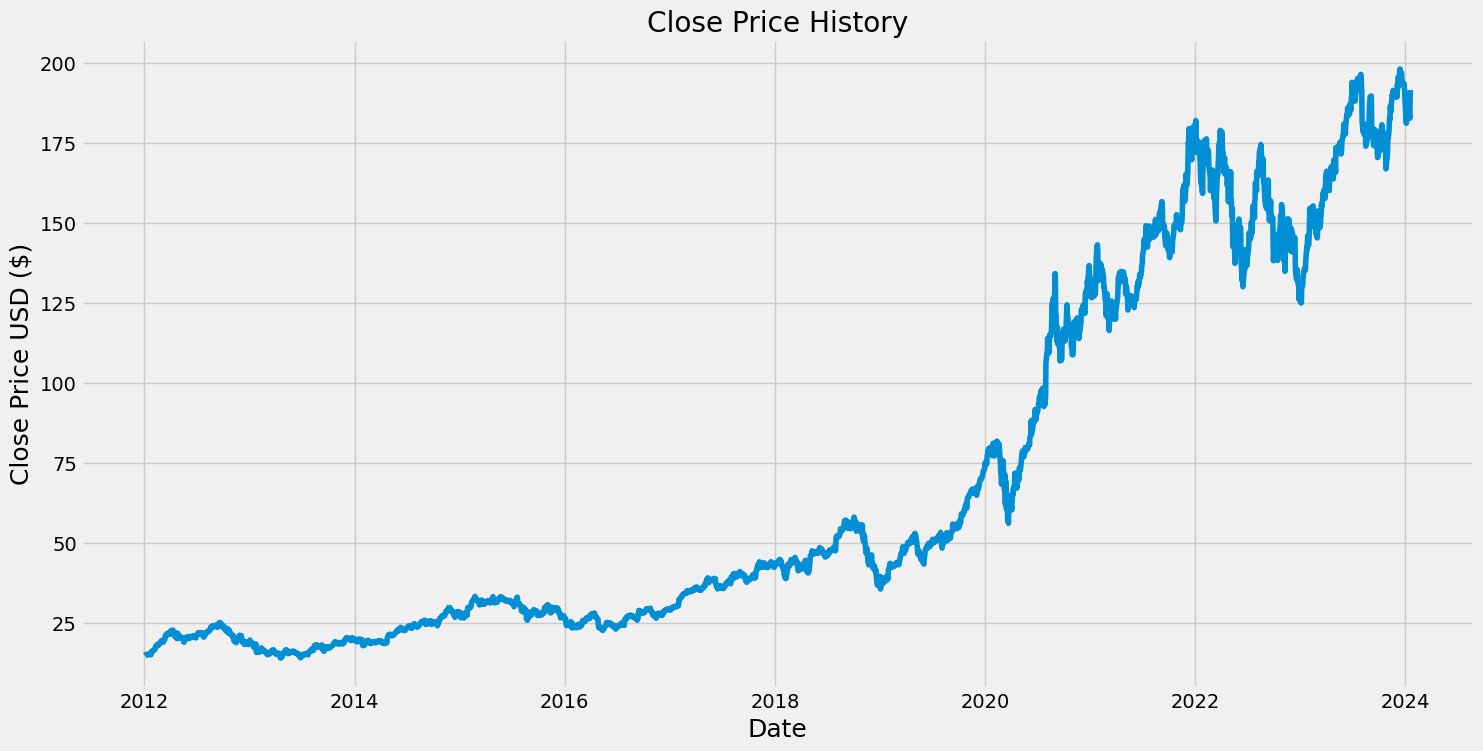

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show()

In [5]:
#Creating a pandas datafram with only the 'Close' column
data = df.filter(['Close'])
dataset = data.values #Converting to a numpy array
#Get no of rows to train model on
training_data_len = math.ceil(len(dataset) * 0.8)
training_data_len

2425

Scaling the Data

In [6]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00401431],
       [0.00444289],
       [0.00533302],
       ...,
       [0.91621526],
       [0.94852375],
       [0.96443357]])

Creating the scaled training dataset

In [7]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(100, len(train_data)):
  #We use tye first 100 results to train the model
  x_train.append(train_data[i-100:i, 0])
  #This contains the desired output (i.e the 101st observation)
  y_train.append(train_data[i, 0])


Convert x_train and y_train to numpy arrays

In [8]:
x_train, y_train  = np.array(x_train), np.array(y_train)

In [9]:
x_train.shape

(2325, 100)

Reshaping the data

In [10]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2325, 100, 1)

Describing the Model

In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

Compiling and Training the model

In [12]:
model.compile(optimizer='adam' , loss='mean_squared_error')
model.fit(x_train, y_train, batch_size = 1, epochs = 10)

Epoch 1/10
2325/2325 [==============================] - 140s 56ms/step - loss: 7.3998e-04
Epoch 2/10
2325/2325 [==============================] - 116s 50ms/step - loss: 3.8704e-04
Epoch 3/10
2325/2325 [==============================] - 118s 51ms/step - loss: 2.6739e-04
Epoch 4/10
2325/2325 [==============================] - 119s 51ms/step - loss: 2.0401e-04
Epoch 5/10
2325/2325 [==============================] - 120s 51ms/step - loss: 1.6636e-04
Epoch 6/10
2325/2325 [==============================] - 117s 50ms/step - loss: 2.1003e-04
Epoch 7/10
2325/2325 [==============================] - 115s 50ms/step - loss: 1.6624e-04
Epoch 8/10
2325/2325 [==============================] - 116s 50ms/step - loss: 1.4190e-04
Epoch 9/10
2325/2325 [==============================] - 116s 50ms/step - loss: 1.5849e-04
Epoch 10/10
2325/2325 [==============================] - 116s 50ms/step - loss: 1.3974e-04


Testing the model

In [13]:
test_data = scaled_data[training_data_len - 100: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(100, len(test_data)):
  x_test.append(test_data[i-100:i, 0])


In [14]:
#converting data to a numpy array
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

19/19 [==============================] - 1s 26ms/step


In [16]:
#Evaluation of model (Root Mean Squared Error)
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
rmse

2.422713326935721

<ipython-input-17-b6280b870211>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


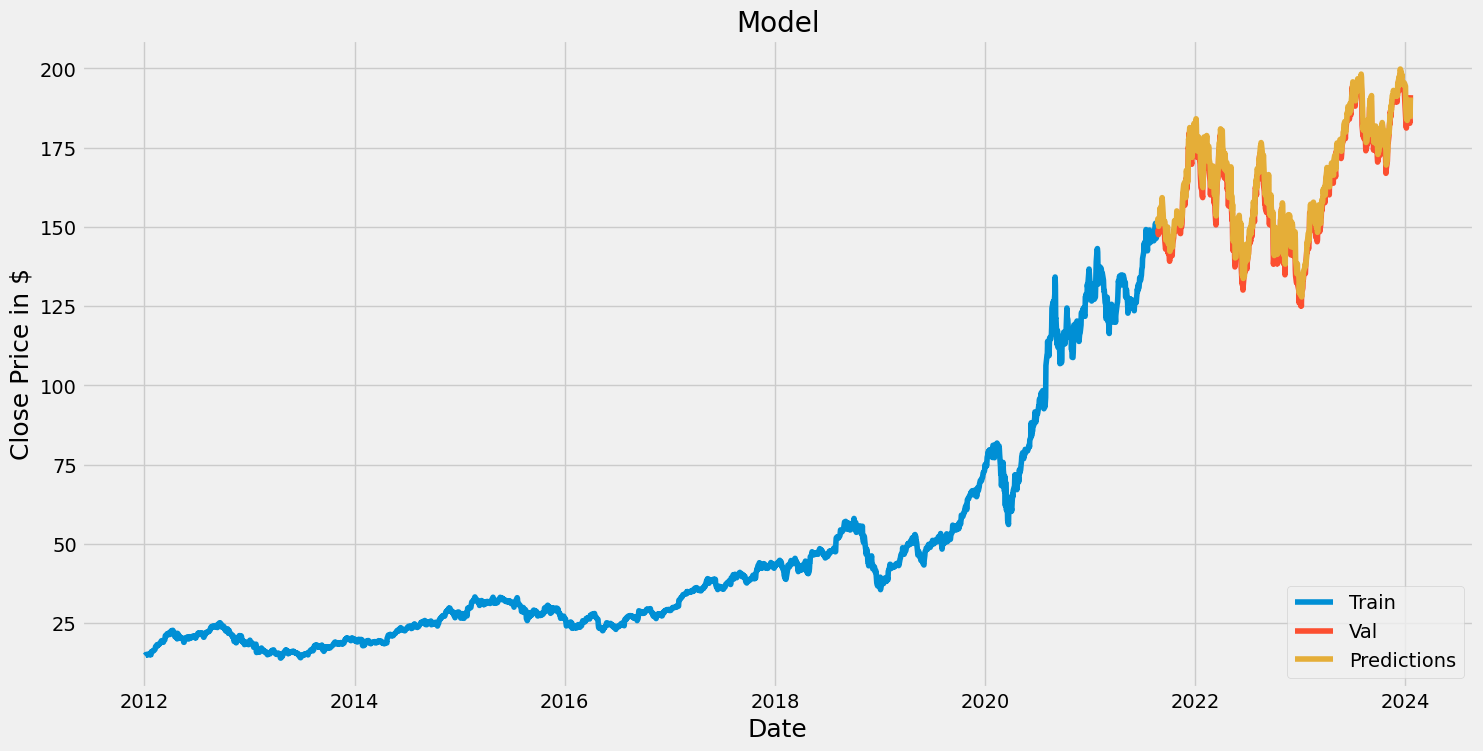

In [17]:
#Plotting the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Vizualizing the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in $', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [18]:
#Showing the valid and predicted prices
valid

,Close,Predictions
Date,,
2021-08-23,149.710007,150.797867
2021-08-24,149.619995,152.510529
2021-08-25,148.360001,152.471039
2021-08-26,147.539993,151.096207
2021-08-27,148.600006,150.150284
...,...,...
2024-01-12,185.919998,187.892685
2024-01-16,183.630005,188.074463
2024-01-17,182.679993,185.818848


Predicting for January 18 2024

In [19]:
apple_quote = yf.download('AAPL', start='2012-01-01' , end ='2024-01-18')
new_df = apple_quote.filter(['Close'])
#Get the last 100 days closingg price value and convert the dataframe to an array
last_100_days = new_df[-100:].values
last_scaled = scaler.transform(last_100_days)
X_test = []
X_test.append(last_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

[*********************100%%**********************]  1 of 1 completed


Getting the predicted price

In [20]:
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

1/1 [==============================] - 0s 33ms/step
[[184.76099]]


In [21]:
apple_quote2 = yf.download('AAPL', start='2024-01-18' , end ='2024-01-19')
apple_quote2['Close']

[*********************100%%**********************]  1 of 1 completed


Date
2024-01-18    188.630005
Name: Close, dtype: float64

# **Summary**

I was able to predict the stock prices of Apple based on past trends. I had to apply Long Short Term Memory method to my Neural Network. This predictions are very good with the predcited value being off by only 4$ (Which is actually pretty good)